In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from mlxtend.plotting import plot_decision_regions
from itertools import chain
import math
from random import seed, shuffle
from scipy.optimize import minimize 
from multiprocessing import Pool, Process, Queue
from collections import defaultdict
from copy import deepcopy
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score as accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

sys.path.insert(1, '../lib/')
import util as ut

sns.set_style('darkgrid')
%matplotlib inline

import warnings
import time
warnings.filterwarnings("ignore")

# Project 4 - A3 and A6

In [2]:
raw_data = '../data/compas-scores-two-years.csv'
df = pd.read_csv(raw_data)

## A3 Method

In [3]:
data = df[(df['race']=='African-American')|(df['race']=='Caucasian')]
data["length_of_stay"] = (pd.to_datetime(data.c_jail_out) - pd.to_datetime(data.c_jail_in)).astype('timedelta64[D]')
data = data[(data.days_b_screening_arrest <= 30) & (data.days_b_screening_arrest >= -30)]
data = data[data.is_recid != -1]
data = data[data.c_charge_degree != "O"]
data = data[data.score_text != "N/A"]
data.drop(['first','last','c_case_number','c_charge_desc','violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
          'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
          'r_offense_date','r_case_number','r_charge_degree'], axis=1,inplace=True)
data['c_days_from_compas'] = data['c_days_from_compas'] .fillna(data['c_days_from_compas'].mode()[0])
data = data.dropna()
X = data.drop(['id','two_year_recid','dob','name','v_type_of_assessment','type_of_assessment'], axis=1)
X.set_index(data.id,inplace=True)
y = data[['two_year_recid']]
y.set_index(data.id,inplace=True)
X = X.drop(['c_offense_date','c_jail_in','c_jail_out','out_custody','in_custody','screening_date','compas_screening_date','v_screening_date'],axis=1)
#convert categorical variables into numeric
X['race']= X['race'].replace(['African-American','Caucasian'],[0,1.0])
X['sex'] = X['sex'].replace(['Male','Female'],[0,1.0])
X['age_cat'] = X['age_cat'].replace(['25 - 45','Less than 25', 'Greater than 45'],[0,1.0,2.0])
X['c_charge_degree'] = X['c_charge_degree'].replace(['M','F'],[0,1.0])
X['score_text'] = X['score_text'].replace(['Low', 'High', 'Medium'],[0,1.0,2.0])
X['v_score_text'] = X['v_score_text'].replace(['Low', 'High', 'Medium'],[0,1.0,2.0])
X = X.fillna(0)


y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1,random_state=44)
x_sensitive_tr = X_train.loc[:, 'race']
x_sensitive_te = X_test.loc[:, 'race']
X_train = X_train.loc[:, X_train.columns != 'race']
X_test = X_test.loc[:, X_test.columns != 'race']

X_train=X_train.reset_index()
X_test=X_test.reset_index()
x_sensitive_tr=x_sensitive_tr.reset_index()
x_sensitive_te=x_sensitive_te.reset_index()

X_train=X_train.drop(['id'], axis=1)
X_test=X_test.drop(['id'], axis=1)
x_sensitive_tr=x_sensitive_tr.drop(['id'], axis=1)
x_sensitive_te=x_sensitive_te.drop(['id'], axis=1)


### Baseline Model

In [4]:
model_base = LogisticRegression(fit_intercept=False).fit(X_train,y_train.flatten())
base_y_train = model_base.predict(X_train)
base_y_test = model_base.predict(X_test)

theta_star = model_base.coef_.flatten()

#metrics
print('train accuracy: ' + str(model_base.score(X_train,y_train.flatten())))
print('test accuracy: ' + str(model_base.score(X_test,y_test.flatten())))

base_calib_train = ut.calibration(base_y_train, y_train.flatten(),x_sensitive_tr['race'].values)
base_calib_test = ut.calibration(base_y_test, y_test.flatten(),x_sensitive_tr['race'].values)

print('train calibration: ' + str(base_calib_train))
print('test calibration: ' + str(base_calib_test))

train accuracy: 0.9639225181598063
test accuracy: 0.9564270152505446
train calibration: 0.0013216642186006933
test calibration: -0.010360962566844933


### Gamma

In [5]:
for g in [0,0.001,0.01,0.05,0.1,0.15,0.2]:
    print('Using gamma = ',g)

    theta_g = ut.model_gamma(X_train,y_train.flatten(),x_sensitive_tr['race'].values,theta_star,g)
   
    #to use score
    model_gamma = LogisticRegression(fit_intercept=False)
    model_gamma.coef_ = theta_g.reshape((1,-1))
    model_gamma.intercept_ = 0
    model_gamma.classes_ = np.array([0,1.0])
    g_y_train = model_gamma.predict(X_train)
    g_y_test = model_gamma.predict(X_test)

    #metrics
    print('train accuracy: ' + str(model_gamma.score(X_train,y_train.flatten())))
    print('test accuracy: ' + str(model_gamma.score(X_test,y_test.flatten())))

    g_calib_train = ut.calibration(g_y_train, y_train.flatten(),x_sensitive_tr['race'].values)
    g_calib_test = ut.calibration(g_y_test, y_test.flatten(),x_sensitive_tr['race'].values)

    print('train calibration difference: ' + str(g_calib_train))
    print('test calibration difference: ' + str(g_calib_test))

Using gamma =  0
train accuracy: 0.47893462469733655
test accuracy: 0.5032679738562091
train calibration difference: 0.13196630217683586
test calibration difference: 0.05514705882352944
Using gamma =  0.001
train accuracy: 0.47893462469733655
test accuracy: 0.5032679738562091
train calibration difference: 0.13196630217683586
test calibration difference: 0.05514705882352944
Using gamma =  0.01
train accuracy: 0.47893462469733655
test accuracy: 0.5032679738562091
train calibration difference: 0.13196630217683586
test calibration difference: 0.05514705882352944
Using gamma =  0.05
train accuracy: 0.47893462469733655
test accuracy: 0.5032679738562091
train calibration difference: 0.13196630217683586
test calibration difference: 0.05514705882352944
Using gamma =  0.1
train accuracy: 0.47893462469733655
test accuracy: 0.5032679738562091
train calibration difference: 0.13196630217683586
test calibration difference: 0.05514705882352944
Using gamma =  0.15
train accuracy: 0.47893462469733655
te

### Fine-Gamma

In [6]:
for g in [0.1]:
    
    print('Using gamma = ',g)
    
    
    theta_fg = ut.model_fg(X_train.values,y_train.flatten(),x_sensitive_tr['race'].values,theta_star,g)

    #to use score
    model_fine_gamma = LogisticRegression(fit_intercept=False)
    model_fine_gamma.coef_ = theta_fg.reshape((1,-1))
    model_fine_gamma.intercept_ = 0
    model_fine_gamma.classes_ = np.array([0,1.0])
    fg_y_train = model_fine_gamma.predict(X_train)
    fg_y_test = model_fine_gamma.predict(X_test)

    #metrics
    print('train accuracy: ' + str(model_fine_gamma.score(X_train,y_train.flatten())))
    print('test accuracy: ' + str(model_fine_gamma.score(X_test,y_test.flatten())))

    fg_calib_train = ut.calibration(fg_y_train, y_train.flatten(),x_sensitive_tr['race'].values)
    fg_calib_test = ut.calibration(fg_y_test, y_test.flatten(),x_sensitive_tr['race'].values)

    print('train calibration difference: ' + str(fg_calib_train))
    print('test calibration difference: ' + str(fg_calib_test))

Using gamma =  0.1
train accuracy: 0.47046004842615013
test accuracy: 0.49019607843137253
train calibration difference: 0.13672643056429867
test calibration difference: 0.05113636363636359


## A6 Method

In [7]:
data = df[(df['race']=='African-American')|(df['race']=='Caucasian')]
data.drop(['violent_recid','vr_charge_degree','vr_case_number','vr_offense_date','vr_charge_desc',
          'c_arrest_date','r_jail_out','r_jail_in','r_days_from_arrest','r_charge_desc',
          'r_offense_date','r_case_number','r_charge_degree'], axis=1,inplace=True)
data['c_offense_date'] = pd.to_datetime(data['c_offense_date'])
data['c_jail_in']= pd.to_datetime(data['c_jail_in'])
data['c_jail_out']= pd.to_datetime(data['c_jail_out'])
data['out_custody']= pd.to_datetime(data['out_custody'])
data['in_custody']= pd.to_datetime(data['in_custody'])
data['screening_date']= pd.to_datetime(data['screening_date'])
data['compas_screening_date']= pd.to_datetime(data['compas_screening_date'])
data['v_screening_date']= pd.to_datetime(data['v_screening_date'])
data['c_days_from_compas'] = data['c_days_from_compas'] .fillna(data['c_days_from_compas'].mode()[0])
X = data.drop(['id','two_year_recid','c_case_number','sex','dob','name'], axis=1)
X.set_index(data.id,inplace=True)
af = data[data.race=='African-American']
ca = data[data.race =='Caucasian']
rate_af = round(af[af['two_year_recid']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['two_year_recid']==1].shape[0]/af.shape[0],2)
print(f'The rate of Recidivism for African-American is {rate_af}\nThe rate of Recidivism for Caucasian is {rate_ca}')
print(f'The Corrected Recidivism rate should be {(rate_af+rate_ca)/2:,} ')
y = data[['two_year_recid']]
y.set_index(data.id,inplace=True)

The rate of Recidivism for African-American is 0.51
The rate of Recidivism for Caucasian is 0.26
The Corrected Recidivism rate should be 0.385 


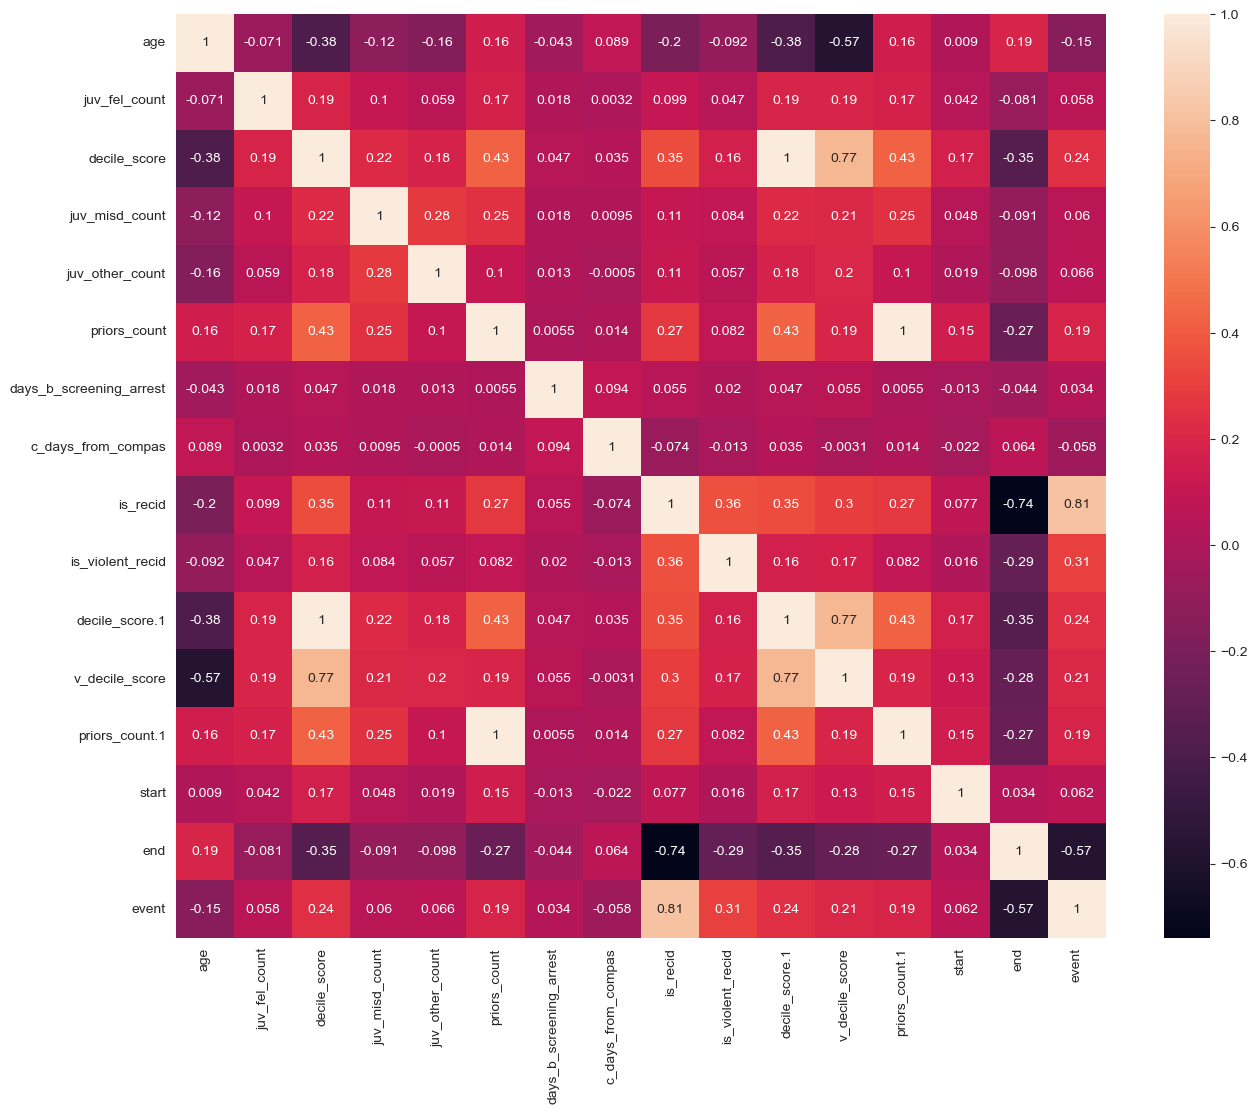

In [8]:
corr = X.corr()
fig,ax = plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True)
plt.show()

In [9]:
enc = OneHotEncoder(handle_unknown='ignore')
X_new = enc.fit(X)
X_new = enc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=.3,random_state=44)


In [10]:
forest = RandomForestClassifier(random_state=44).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9766937669376694
[[932  43]
 [  0 870]]
0.02107992678462478


The model showed that African-American has a higher Recidivism rate compared to Caucasian, and in reality the rate should be pretty much the same

In [11]:
categorical_features = ['first','last','age_cat','race','c_charge_degree','c_charge_desc','type_of_assessment',
                       'score_text','v_type_of_assessment','v_score_text']

In [12]:
selected_column= X[categorical_features]
categorical_df = selected_column.copy()

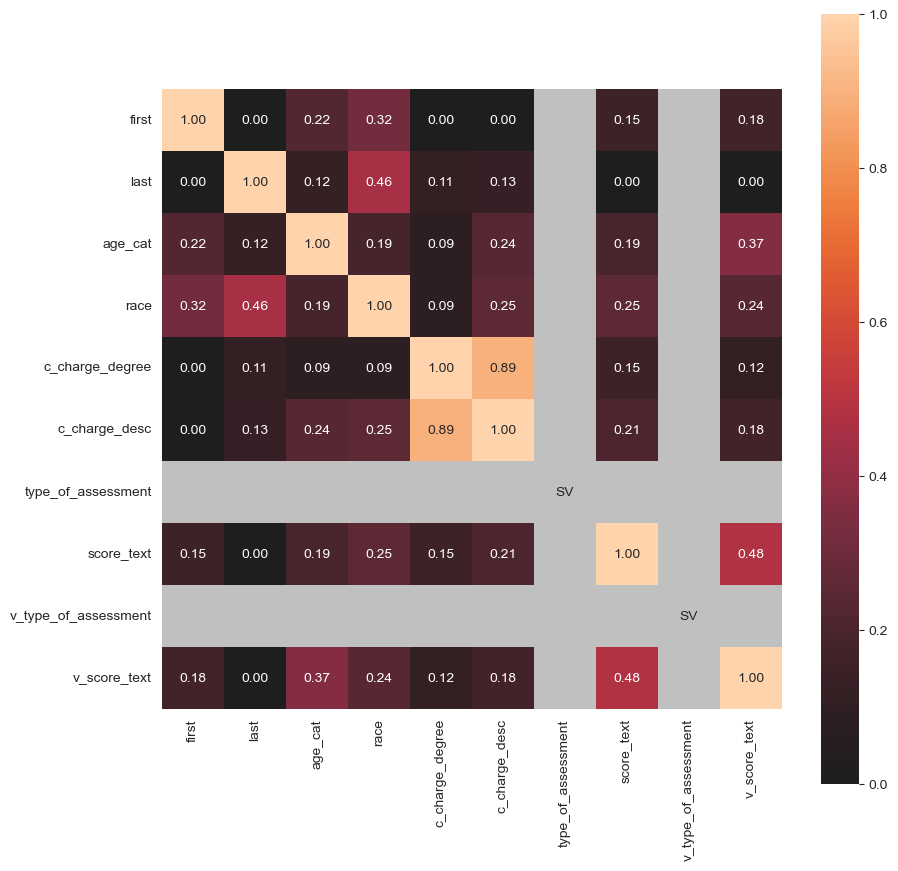

In [13]:
categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(10,10))

Here we set the correlation threshold to be no less than 0.2, and we get the $e_{i}$ to be first, last, c_charge_desc, score_text and v_score_text

In [14]:
e_list = ['first', 'last', 'c_charge_desc', 'score_text' , 'v_score_text']
exclude_e_s = [
 'compas_screening_date',
 'age',
 'age_cat',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_jail_in',
 'c_jail_out',
 'c_offense_date',
 'c_days_from_compas',
 'c_charge_degree',
 'is_recid',
 'is_violent_recid',
 'type_of_assessment',
 'decile_score.1',
 'screening_date',
 'v_type_of_assessment',
 'v_decile_score',
 'v_screening_date',
 'in_custody',
 'out_custody',
 'priors_count.1',
 'start',
 'end',
 'event']
e = X[e_list]
new_X = X[exclude_e_s]
s = X[['race']]

### Handling Conditional Discrimination

![a3.jpg](../figs/a3.jpg)

![a4.jpg](../figs/a4.jpg)

For Algorithm 4, $p^\star(+|e_i)$, $p(+|e_i,\text{gender})$ is changed each time for different i, I have no idea what $G_i$ is the description is too abstract, as so I will define $G_i$ as a constant $C$ (Hyperparameter)

## Algorithm 1

![a1.jpg](../figs/a1.jpg)

In [15]:
New_X = ut.local_massaging(new_X,s,e,y)

In [16]:
af = New_X[New_X.race=='African-American']
ca = New_X[New_X.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)

In [17]:
rate_af,rate_ca 

(0.46, 0.44)

We can see the discrimation is being balanced 

In [18]:
New_y = New_X.new_label
New_X_copy = New_X.copy()
New_X_copy.drop(['new_label'],axis=1,inplace=True)
X_new = enc.fit(New_X_copy)
X_new = enc.transform(New_X_copy)
X_train, X_test, y_train, y_test = train_test_split(X_new,New_y,test_size=.3,random_state=42)
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)

Accuracy

In [19]:
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = New_X.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9463414634146341
[[936  70]
 [ 29 810]]
0.043960286817429695


### Algorithm 2

![a2.jpg](../figs/a2.jpg)

In [20]:
X_New = ut.local_preferential_sampling(new_X,s,e,y)
af = X_New[X_New.race=='African-American']
ca = X_New[X_New.race =='Caucasian']
rate_af = round(af[af['new_label']==1].shape[0]/af.shape[0],2)
rate_ca = round(ca[ca['new_label']==1].shape[0]/ca.shape[0],2)
rate_af,rate_ca

(0.5, 0.4)

In [21]:
y_New = X_New.new_label
X_New_copy = X_New.copy()
X_New_copy.drop(['new_label'],axis=1,inplace=True)
X_new = enc.fit(X_New_copy)
X_new = enc.transform(X_New_copy)
X_train, X_test, y_train, y_test = train_test_split(X_new,y_New,test_size=.3,random_state=42)
forest = RandomForestClassifier(random_state=42).fit(X_train, y_train) 
y_pred_test = forest.predict(X_test)

In [22]:
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
cali_X = X_New.loc[y_test.index]
cali_X['label'] = y_test
cali_X['pred'] = y_pred_test
af_X = cali_X[cali_X.race=='African-American']
ca_X =  cali_X[cali_X.race=='Caucasian']
print(np.abs(accuracy_score(af_X.label, af_X.pred)-accuracy_score(ca_X.label, ca_X.pred)))

0.9588075880758807
[[929  73]
 [  3 840]]
0.06168413311270449


## Conclusion:
We can see that the accuracy and Calibration slightly decreased after modified algorithms but in return of a good elimination towards bad discrimination. After all we conclude that the drop of accuracy is worth the shot.